In [22]:
import mlflow
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
from pyarrow import parquet
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe

In [2]:
experiment_name = "Amazon Review XGBoost PCA Model"
mlflow.set_experiment(experiment_name)
feature_cols = [f"emb_{i}" for i in range(768)]

2026/02/10 12:44:02 INFO mlflow.tracking.fluent: Experiment with name 'Amazon Review XGBoost PCA Model' does not exist. Creating a new experiment.


In [4]:
train_df = parquet.read_table('data/train_data.parquet').to_pandas()
val_df = parquet.read_table('data/validation_data.parquet').to_pandas()
test_df = parquet.read_table('data/test_data.parquet').to_pandas()

In [5]:
x_train = train_df[feature_cols]
y_train = train_df['rating_bins']
train_df.shape, x_train.shape, y_train.shape

((508964, 770), (508964, 768), (508964,))

In [6]:
x_val = val_df[feature_cols]
y_val = val_df['rating_bins']
val_df.shape, x_val.shape, y_val.shape

((114517, 770), (114517, 768), (114517,))

In [7]:
scaler = StandardScaler()
scaler.fit(x_train)
pickle.dump(scaler, open('best_model/classification/pca/scaler.pkl', 'wb'))
x_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [10]:
pca = PCA(n_components=400)
pca.fit(x_scaled)
pickle.dump(pca, open('best_model/classification/pca/pca_model.pkl', 'wb'))
print("Explained variance:", pca.explained_variance_ratio_)
print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))

Explained variance: [0.11099198 0.07445432 0.04265793 0.03999133 0.03709449 0.0270019
 0.02568469 0.02211471 0.02183969 0.01946505 0.01863171 0.01587269
 0.0141749  0.01341833 0.01235799 0.01153587 0.01106439 0.01061636
 0.01023455 0.00984829 0.00908477 0.00863511 0.0083616  0.0078179
 0.00747004 0.00713374 0.00658549 0.00643554 0.00613871 0.00611875
 0.00588933 0.00575302 0.00559659 0.0052042  0.00510644 0.00493258
 0.00480923 0.00458734 0.00446107 0.0044046  0.0041075  0.00406219
 0.00385532 0.00377941 0.00370301 0.00366883 0.00360646 0.00352551
 0.00345809 0.00330349 0.00328385 0.00321647 0.00314967 0.00304745
 0.00297622 0.00291746 0.00291162 0.00281535 0.00274731 0.00267027
 0.00264685 0.00258597 0.00254944 0.00250718 0.00245685 0.00241049
 0.00233788 0.00231547 0.00228359 0.00219859 0.00215837 0.00210749
 0.00206873 0.00203116 0.0019855  0.00198064 0.00191982 0.00188047
 0.00187522 0.00183121 0.00179719 0.00179583 0.00178955 0.00174899
 0.00173082 0.00170544 0.00168293 0.00166754

In [8]:
sample_size = 50000
sample_x = x_train.sample(n=sample_size)
sample_y = y_train.sample(n=sample_size)
sample_x.shape, sample_y.shape

((50000, 768), (50000,))

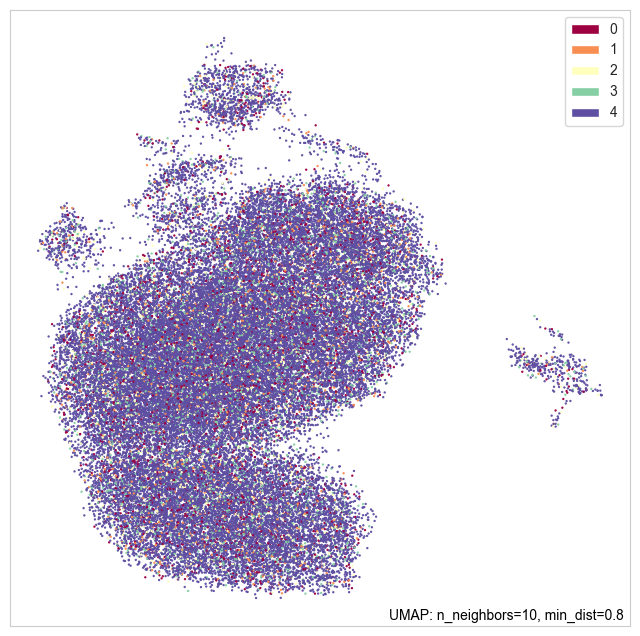

In [10]:
from umap import UMAP
import umap.plot

sample_x_scaled = scaler.transform(sample_x)
sample_pca = pca.transform(sample_x_scaled)
u_map = UMAP(n_components=2, metric="euclidean", n_neighbors=10, min_dist=0.8).fit(sample_pca)
umap.plot.points(u_map, labels=sample_y)
plt.show()

In [8]:
def get_sample_weight_dict(df):
    rating_counts = df['rating'].value_counts()
    print(f"rating value counts === {rating_counts}")
    max_rating_count = rating_counts.max()
    weight_dict = (max_rating_count / rating_counts).to_dict()
    print(f"weight_dict === {weight_dict}")
    return weight_dict

sample_weight_dict = get_sample_weight_dict(train_df)
training_sample_weights = train_df['rating'].map(sample_weight_dict).values
val_sample_weights = val_df['rating'].map(sample_weight_dict).values

rating value counts === rating
5.0    401758
4.0     35073
1.0     32560
3.0     23465
2.0     16108
Name: count, dtype: int64
weight_dict === {5.0: 1.0, 4.0: 11.454908334046133, 1.0: 12.339004914004914, 3.0: 17.121585339867888, 2.0: 24.94151974174323}


In [11]:
pca_x_train = pca.transform(x_scaled)
pca_x_val = pca.transform(x_val_scaled)

In [12]:
dmatrix_pca_train = xgb.DMatrix(pca_x_train, label=y_train, weight=training_sample_weights)
dmatrix_pca_val = xgb.DMatrix(pca_x_val, label=y_val, weight=val_sample_weights)
evals_pca = [(dmatrix_pca_train, "train"), (dmatrix_pca_val, "validation")]

In [14]:
params = {
     "booster": "gbtree",
    "device": "gpu",    
    "tree_method": "hist",
    "eval_metric": ["mlogloss","merror"],
    "num_class":5,
    "objective": "multi:softprob"
}
model = xgb.train(
   params=params,
   dtrain=dmatrix_pca_train,
   num_boost_round=1000,
   evals=evals_pca,
   verbose_eval=50,
   early_stopping_rounds=50
)

[0]	train-mlogloss:1.50936	train-merror:0.57436	validation-mlogloss:1.51434	validation-merror:0.59602
[50]	train-mlogloss:0.91769	train-merror:0.31143	validation-mlogloss:1.12818	validation-merror:0.49640
[100]	train-mlogloss:0.73691	train-merror:0.20754	validation-mlogloss:1.10079	validation-merror:0.48576
[150]	train-mlogloss:0.60853	train-merror:0.14143	validation-mlogloss:1.09682	validation-merror:0.48102
[200]	train-mlogloss:0.50982	train-merror:0.09862	validation-mlogloss:1.10291	validation-merror:0.48070
[250]	train-mlogloss:0.43011	train-merror:0.07054	validation-mlogloss:1.11275	validation-merror:0.48042
[294]	train-mlogloss:0.37291	train-merror:0.05330	validation-mlogloss:1.12461	validation-merror:0.48284


In [13]:
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score, balanced_accuracy_score

def get_scores(y_true, y_preds_proba, loss_metric="log_loss"):
    labels = [0, 1, 2, 3, 4]
    val_log_loss = log_loss(y_true, y_preds_proba,
                            sample_weight=val_sample_weights, labels=[0, 1, 2, 3, 4])
    y_preds = y_preds_proba.argmax(axis=-1)
    accuracy = balanced_accuracy_score(y_true, y_preds)

    precision_weighted = precision_score(y_true, y_preds, average="weighted", labels=labels)

    recall_weighted = recall_score(y_true, y_preds, average="weighted", labels=labels)

    f1_weighted = f1_score(y_true, y_preds, average="weighted", labels=labels)
    f1_macro = f1_score(y_true, y_preds, average="macro", labels=labels)
    precision_macro = precision_score(y_true, y_preds, average="macro",labels=labels)
    recall_macro = recall_score(y_true, y_preds, average="macro", labels=labels)
    if loss_metric == "log_loss":
        loss = val_log_loss
    else:
        loss = -accuracy

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
         "precision_weighted": precision_weighted,
            "recall_weighted" : recall_weighted,
            "f1_weighted": f1_weighted,
            "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
    }
    return metrics

In [18]:
best_iteration = model.best_iteration
print(f"best_iteration = {best_iteration}")
base_pred_proba = model.predict(dmatrix_pca_val, iteration_range=(0, best_iteration))
metrics = get_scores(y_val, base_pred_proba)
print(params)
print(metrics)

best_iteration = 244
{'booster': 'gbtree', 'device': 'gpu', 'tree_method': 'hist', 'eval_metric': ['mlogloss', 'merror'], 'num_class': 5, 'objective': 'multi:softprob'}
{'loss': 1.1110826208145492, 'accuracy': 0.5197912987496148, 'precision': 0.49793192886980436, 'recall': 0.5197955105653185, 'f1': 0.49886447431473846}


In [26]:
artificat_path = "pca_embeddings_fine_tuned"
local_pkl_path = "app/pca_embeddings_models/model"


def tune_model(params):
    xgb_model = xgb.train(
        params=params,
        dtrain=dmatrix_pca_train,
        num_boost_round=15000,
        early_stopping_rounds=50,
        evals=evals_pca,
        verbose_eval=50
    )
    y_pred_proba = xgb_model.predict(dmatrix_pca_val, iteration_range=(0, xgb_model.best_iteration))
    with mlflow.start_run(nested=True) as run:
        mlflow.log_params(params)
        metrics = get_scores(y_val, y_pred_proba)
        print(params)
        print(metrics)
        mlflow.log_metrics(metrics)
        mlflow.xgboost.log_model(xgb_model, name=artificat_path)
        pkl_file_name = f"{local_pkl_path}_{run.info.run_id}.pkl"
        pickle.dump(xgb_model, open(pkl_file_name, 'wb'))
        mlflow.log_artifact(local_path=pkl_file_name, artifact_path=artificat_path)
        metrics["status"] = STATUS_OK
        return metrics

In [27]:
def fine_tune_model(ml_flow_run_name, search_space):
    with mlflow.start_run(run_name=ml_flow_run_name):
        # Run optimization
        trials = Trials()
        best_params = fmin(
            fn=tune_model,
            space=search_space,
            algo=tpe.suggest,
            max_evals=15,
            trials=trials,
            verbose=True,
        )
        # Find and log best results
        best_trial = min(trials.results, key=lambda x: x["loss"])
        # Log optimization results
        mlflow.log_params(best_params)
        mlflow.log_metrics(
            {
                "best_val_log_loss": best_trial["loss"],
                "best_accuracy": best_trial["accuracy"],
                "best_precision": best_trial["precision"],
                "best_recall": best_trial["recall"],
                "best_f1": best_trial["f1"],
                "total_trials": len(trials.trials),
                "optimization_completed": 1,
            }
        )

In [1]:
search_space_pca = {
    "objective": "multi:softprob",
     "booster": "gbtree",
    "device": "gpu",    
    "tree_method": "hist",
    "eval_metric": "mlogloss",
    "num_class":5, 
    "eta" : hp.uniform("eta",0.01,0.3),
    "gamma" : hp.uniform("gamma",0,1.5),
    "max_depth" : hp.uniformint("max_depth", 4,  7),
    "lambda" : hp.uniform("lambda",1,5),
    "alpha": hp.uniform("alpha",0,5),
    "min_child_weight": hp.uniformint("min_child_weight",1,10)   
}
fine_tune_model("pca_hyper_parameter_search", search_space_pca)

NameError: name 'hp' is not defined

In [14]:
scaler = pickle.load(open("best_model/classification/pca/scaler.pkl", "rb"))
pca = pickle.load(open("best_model/classification/pca/pca_model.pkl", "rb"))
x_val_scaled = scaler.transform(x_val)
pca_x_val = pca.transform(x_val_scaled)
dmatrix_pca_val = xgb.DMatrix(pca_x_val, label=y_val, weight=val_sample_weights)

In [15]:
pca_tuned_model_step_1 = pickle.load(open("best_model/classification/pca/fine_tune_pca_step_1.pkl", "rb"))
print(pca_tuned_model_step_1.best_iteration)
pred_proba = pca_tuned_model_step_1.predict(dmatrix_pca_val, iteration_range=(0, pca_tuned_model_step_1.best_iteration))
metrics = get_scores(y_val, pred_proba)
print(metrics)

1840
{'loss': 1.0493673758825257, 'accuracy': 0.5373213269092778, 'precision_weighted': 0.8411061149295618, 'recall_weighted': 0.7734834129430564, 'f1_weighted': 0.8008789380602066, 'f1_macro': 0.494226429326568, 'precision_macro': 0.47269545987023703, 'recall_macro': 0.5373213269092778}


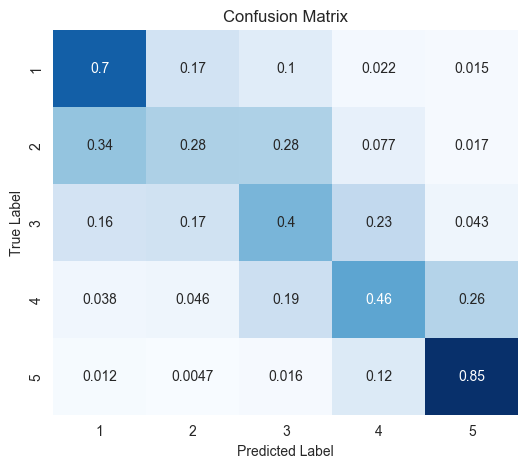

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_pred = pred_proba.argmax(axis=-1)
cm = confusion_matrix(y_true=y_val, y_pred=y_pred, 
                                    labels=[0, 1, 2, 3, 4], normalize="true")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

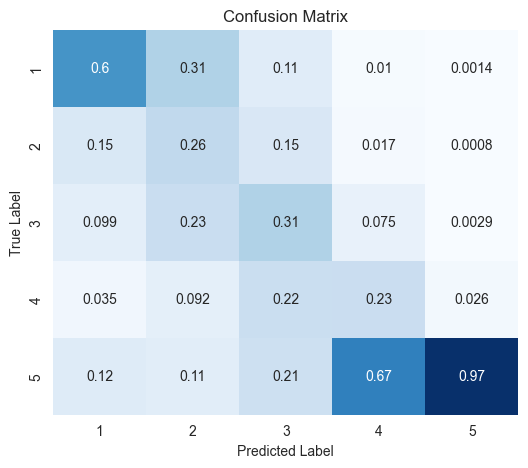

In [21]:
cm = confusion_matrix(y_true=y_val, y_pred=y_pred, 
                                    labels=[0, 1, 2, 3, 4], normalize="pred")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()